In [16]:
import os
import re
import datetime
import pandas as pd

In [17]:
assets_df = pd.read_csv('asset_list.csv')
assets_df = pd.concat([assets_df, pd.read_csv('asset_list-2021.csv')])
assets_df['updated_date'] = pd.to_datetime(assets_df['updated_date'], format="%Y-%m-%d").dt.date
assets_df

,symbol,usage,updated_date
0,AAL,nasdaq100,2015-12-31
1,AAPL,nasdaq100,2015-12-31
2,ADBE,nasdaq100,2015-12-31
3,ADI,nasdaq100,2015-12-31
4,ADP,nasdaq100,2015-12-31
...,...,...,...
196,WDAY,nasdaq100,2022-01-03
197,XEL,nasdaq100,2022-01-03
198,XLNX,nasdaq100,2022-01-03
199,ZM,nasdaq100,2022-01-03


In [18]:
def get_assets(assets_df, todate):
    last_updated_date = assets_df[assets_df['updated_date'] <= todate]['updated_date'].values[-1]
    symbols = assets_df[assets_df['updated_date'] == last_updated_date]['symbol'].values
    symbols = list(symbols)
    return symbols

In [19]:
len(get_assets(assets_df, datetime.date(2016, 1, 1)))

96

In [46]:
def get_eps(file):
    df = pd.read_csv(file, usecols=['release_date', 'period_end', 'eps_forecast', 'code']).dropna()
    df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d').dt.date
    df = df[df['eps_forecast'] != "--"]
    df['eps_forecast'] = df['eps_forecast'].astype(float)
    return df

In [47]:
folder = 'data/investingcom'
all_eps = pd.DataFrame()
for fn in os.listdir(folder):
    fpath = os.path.join(folder, fn)
    df = get_eps(fpath)
    all_eps = pd.concat([all_eps, df])
all_eps

,release_date,period_end,eps_forecast,code
0,2022-04-28,2022 Q1,-2.46,AAL
1,2022-01-20,2021 Q4,-1.48,AAL
2,2021-10-21,2021 Q3,-1.04,AAL
3,2021-07-22,2021 Q2,-2.03,AAL
4,2021-04-22,2021 Q1,-4.30,AAL
...,...,...,...,...
13,2019-02-28,2019 Q1,-0.01,ZS
14,2018-12-05,2018 Q4,-0.05,ZS
15,2018-09-05,2018 Q3,-0.05,ZS
16,2018-06-06,2018 Q2,-0.08,ZS


In [72]:
all_eps.to_csv('./data/all_EPS.csv')

In [22]:
E_DATE = datetime.date.today()
class DateListGenerator():

    """
    Attributes:
        connect : Database connection
    """

    def __init__(self, tradedates):
        """
        Args:
            tradedates (pd.DataFrame): full trade date with all columns
        """
        self.tradedates = tradedates

    def get_tradedate(self):
        """get trade date series from database

        Args:
            table (str): date features table name
        Returns:
            Series: All trade dates
        """

        tradedates = self.tradedates['date']
        tradedates = pd.to_datetime(tradedates, format='%Y-%m-%d')
        return tradedates

    def check_date_action(self, this_date, rebalance_freq):
        """ check what tyype is this_date is
            -1 means it is not trade date e.g. Sunday
            1 means it isrebalance date e.g. every first trade date of a month
            2 means it is trigger date e.g the date which is trade date but not rebalance date

        Args:
            this_date (date): the date to check
            rebalance_freq (str): how long will rebalance

        Returns:
            int: date_action type
        """

        tradedates = self.tradedates.set_index('date')
        tradedates.index = pd.to_datetime(
            tradedates.index, format='%Y-%m-%d').date

        if this_date not in tradedates.index:
            return -1

        else:
            datelist_all = pd.DataFrame(
                list(tradedates.index), columns=['date'])
            datelist_all.index = datelist_all.date

            datelist_rb = self.rebalance_date(
                datelist_all.index, rebalance_freq)
            datelist_rb = datelist_rb[datelist_rb <= this_date]

            if this_date == datelist_rb.iloc[-1]:
                return 1
            else:
                return 2

    def gen_datelist(self, rebalance_freq, liveprod_period, maxdate=E_DATE,
                     begin_date=None, end_date=E_DATE, mode="backtest"):
        """Gen predict date list based on MPT rule

        Args:
            rebalance_freq (str): how long will rebalance
            liveprod_period (int): how many month for liveprod
            maxdate (date): last data's date
            begin_date (None, optional): First data date should later than this date
            end_date (TYPE, optional): Last data date should earier than this date
            mode (str, optional): training mode (option: 'backtest', 'liveprod')

        Returns:
            pd.DataFrame: list all prediction date
        """

        datelist = pd.to_datetime(
            self.tradedates['date'], format='%Y-%m-%d').dt.date
        datelist_all = pd.DataFrame(list(datelist), columns=['date'])
        datelist_all.index = datelist_all.date

        # cut begin-date if set
        if begin_date is not None:
            datelist_all = datelist_all[datelist_all.index >= begin_date]

        # cut end-date if set
        if end_date is not None:
            datelist_all = datelist_all[datelist_all.index <= end_date]

        datelist_rb = self.rebalance_date(datelist_all.index, rebalance_freq)
        datelist_rb = datelist_rb[datelist_rb < maxdate]
        if mode == 'liveprod':
            datelist_rb = datelist_rb.tail(liveprod_period)
        datelist_rb = datelist_rb.reset_index(drop=True)

        return datelist_rb

    def rebalance_date(self, dates, freq='M'):
        """Get rebalance date base on frequence

        Args:
            dates (Index): All trade dates in special period
            freq (str, optional): the rebalance frequence

        Returns:
            pd.DataFrame: the selected rebalance date
        """
        dates = pd.to_datetime(dates)
        dts = pd.Series(dates, index=dates).sort_values()
        if '+' in freq:
            temp = []
            for sub_freq in freq.split('+'):
                sub_dts = self.group_series(dts, *self.parse_freq(sub_freq))
                temp.append(sub_dts)
            results = pd.concat(temp).drop_duplicates().sort_values()
        else:
            results = self.group_series(dts, *self.parse_freq(freq))

        results = results.reset_index(drop=True).rename(freq)
        results_df = results.to_frame()
        results_df[freq] = pd.to_datetime(
            results_df[freq], format='%Y-%m-%d').dt.date

        return results_df[freq]

    @staticmethod
    def group_series(dates, n_period, period, nth):
        """
        Args:
            dates (pd.Series): All trade dates in special period
            n_period (int): number of period
            period (str): frequency period
            nth (int): number of start point

        Returns:
            pd.DataFrame: the selected rebalance date
        """
        err = 'only support pandas.datetimeindex'
        assert isinstance(dates.index, pd.DatetimeIndex), err
        period_index = dates.index.to_period(period)
        if period != 'D':
            results = dates.groupby(period_index).nth(nth)
        else:
            results = dates[nth::n_period]
            n_period = 0
        if n_period > 1:
            results = results[::int(n_period)]
        return results.reset_index(drop=True)

    @staticmethod
    def parse_freq(s, default_num=1, default_nth=0):
        """Split frequency
        Args:
            s (str): rebalance frequence (e.g. 2M, 10D)
            default_num (int, optional): number of period
            default_nth (int, optional): number of start point

        Returns:
            num (int): number of period
            p (str): frequency period
            nth (int): number of start point

        Raises:
            KeyError: Wrong input format of Frequency
        """
        r = re.compile('(|\d+)([A-Za-z]+)(\d+|)')
        match = r.match(s)
        if not match:
            raise KeyError('Invalid format of Frequency [{}]'.format(s))
        num, p, nth = match.groups()
        num = int(num) if len(num) > 0 else default_num
        nth = int(nth) if len(nth) > 0 else default_nth
        return num, p, nth


In [29]:
tradedate_df = pd.read_csv('date_features.csv')
# tradedate_df = tradedate_df.set_index('date')
# tradedates = pd.to_datetime(tradedate_df.index, format='%Y-%m-%d').date
datelist_gener = DateListGenerator(tradedate_df)
tradedates = datelist_gener.gen_datelist('M', None, begin_date=datetime.date(2016, 1, 1))
tradedates = list(set(tradedates))
tradedates.sort()

In [32]:
def year_mapping(dt):
    if dt.month in [1, 2, 3]:
        return 1
    elif dt.month in [4, 5, 6]:
        return 2
    elif dt.month in [7, 8, 9]:
        return 3
    elif dt.month in [10, 11, 12]:
        return 4

In [52]:
nstocks = 20
total_net = 1.0

total_record = pd.DataFrame()
for rb in tradedates:
    assets = get_assets(assets_df, rb)
    sub_eps_df = all_eps[all_eps['code'].isin(assets)]
    sub_eps_df = sub_eps_df.set_index('code', drop=True)
#     print(len(list(set(sub_eps_df['code']))))
    quarter = year_mapping(rb)
    eps_current = "{} Q{}".format(rb.year, quarter)
    if quarter == 1:
        eps_previous = "{} Q4".format(rb.year-1)
    else:
        eps_previous = "{} Q{}".format(rb.year, quarter-1)

#     # eps_q1 -> eps_previous
#     # eps_q2 -> eps_current
    eps_q1 = sub_eps_df[sub_eps_df['period_end'] == eps_previous]['eps_forecast']
    eps_q1 = eps_q1.loc[~eps_q1.index.duplicated(keep='last')]
    eps_q1 = eps_q1[eps_q1 > 0]
    eps_q1.name = 'eps_q1'
    eps_q2 = sub_eps_df[sub_eps_df['period_end'] == eps_current]['eps_forecast']
    eps_q2 = eps_q2.loc[~eps_q2.index.duplicated(keep='last')]
    eps_q2 = eps_q2[eps_q2 > 0]
    eps_q2.name = 'eps_q2'

    eps_df = pd.concat([eps_q1, eps_q2], axis=1)
    eps_df = eps_df.dropna()
    factor_eps = (eps_df['eps_q2'] - eps_df['eps_q1']) / eps_df['eps_q1']
    factor_eps.name = 'factor_eps'

    eps_df = pd.concat([eps_df, factor_eps], axis=1)
    eps_df = eps_df.dropna()
    factor_eps = factor_eps.sort_values(ascending=False)
    trade_stock = list(factor_eps.index)[:nstocks]
    eps_df = eps_df.loc[trade_stock, :]

    ratio = total_net / len(eps_df.index)
    eps_df['ratio'] = ratio
    eps_df['trade_date'] = rb
    eps_df.index.name = 'code'
    total_record = pd.concat([total_record, eps_df])
total_record

,eps_q1,eps_q2,factor_eps,ratio,trade_date
code,,,,,
INCY,0.0900,0.1700,0.888889,0.05,2016-01-04
KLAC,0.5200,0.9800,0.884615,0.05,2016-01-04
ADP,0.6800,1.1800,0.735294,0.05,2016-01-04
WBA,0.7500,1.2800,0.706667,0.05,2016-01-04
VRTX,0.1700,0.2900,0.705882,0.05,2016-01-04
...,...,...,...,...,...
ADP,1.6300,2.0800,0.276074,0.05,2022-02-01
MRVL,0.3847,0.4817,0.252145,0.05,2022-02-01
ROST,0.7833,0.9618,0.227882,0.05,2022-02-01


In [53]:
total_record.to_csv('data/investing_FSP_ratio.csv')

In [54]:
base_df = pd.read_csv('data/factset_ratio_beta.csv')
base_df['date'] = pd.to_datetime(base_df['date'], format="%Y-%m-%d").dt.date
base_df

,date,code,ratio,write_time
0,2015-12-31,ADI,0.050000,NaN
1,2015-12-31,ADP,0.050000,NaN
2,2015-12-31,AMGN,0.050000,NaN
3,2015-12-31,FAST,0.050000,NaN
4,2015-12-31,ILMN,0.050000,NaN
...,...,...,...,...
30587,2022-01-27,PCAR,0.052675,2022-02-08 08:36:20
30588,2022-01-27,ROST,0.051433,2022-02-08 08:36:20
30589,2022-01-27,TMUS,0.053982,2022-02-08 08:36:20
30590,2022-01-27,WDAY,0.047628,2022-02-08 08:36:20


In [66]:
td = list(set(total_record['trade_date']))
td.sort()
result = pd.Series()
acc = pd.Series()
for dt in td:
    base_symbol = list(base_df[base_df['date'] == dt]['code'].values)
    base_symbol.sort()
    new_symbol = list(total_record[total_record['trade_date'] == dt].index.values)
    new_symbol.sort()
#     print(base_symbol)
#     print(new_symbol)
    a_set = set(base_symbol)
    b_set = set(new_symbol)
    
    result[dt] = len(a_set.intersection(b_set))
    acc[dt] = len(a_set.intersection(b_set))/nstocks
result

c:\users\ho sumwai\appdata\local\programs\python\python36-64\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\ho sumwai\appdata\local\programs\python\python36-64\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


2016-01-04    11
2016-02-01     6
2016-03-01     2
2016-04-01    10
2016-05-02     6
              ..
2021-10-01    11
2021-11-01     6
2021-12-01     1
2022-01-03    13
2022-02-01     0
Length: 74, dtype: int64

In [71]:
result.name = 'common asset number'
acc.name = '% of total assets'
res = pd.concat([result, acc], axis=1)
res.iloc[:-2, :].mean()

common asset number    7.166667
% of total assets      0.358333
dtype: float64

In [69]:
res.to_csv('./data/result.csv')

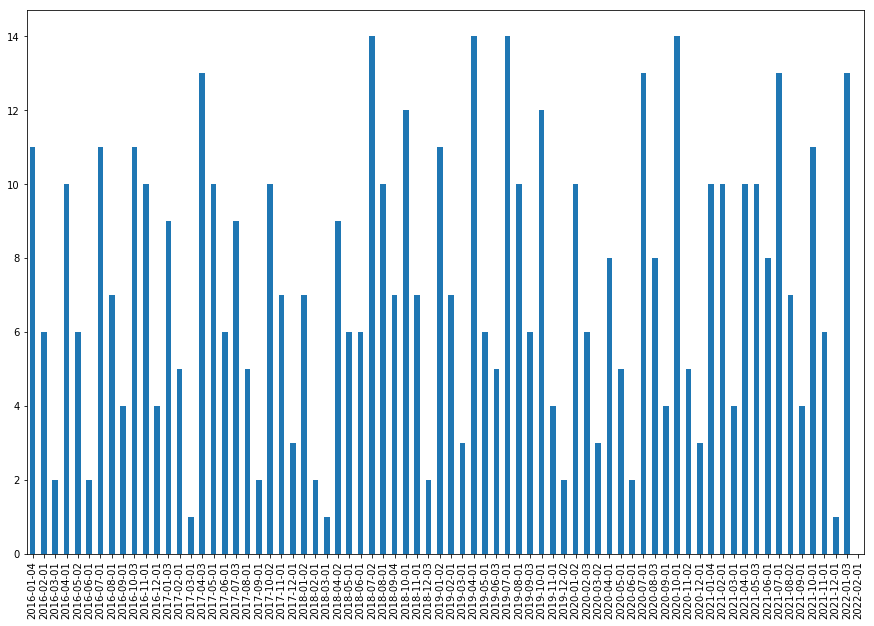

In [65]:
result.plot(kind='bar', figsize=(15, 10))